In [324]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [340]:
df = pd.read_csv("train.csv")


bad_columns = ["Id"]

for column in df.columns:
  null_count = 0
  for i, row in df.iterrows():
    if pd.isna(row[column]):
      null_count += 1
  if null_count / df.shape[0] > 0.4:
    bad_columns.append(column)

df = df.drop(columns=bad_columns, axis=1)

In [341]:
# Remove all columns that mostly have the same value (>90%)

low_variability_columns = []

for column in df.columns:
  if df[column].value_counts(normalize=True).values[0] > 0.9:
    low_variability_columns.append(column)
df = df.drop(columns=low_variability_columns, axis=1)

The following correlations make sesne

- GarageYrBlt, YearBuilt
- Exterior1st, Exterior2nd
- BsmtFinSF2, BsmtFinType2
- GrLivArea, 1stFlrSF
- BldgType, MSSubClass
- 1stFlrSF, TotalBsmtSF

We'll get rid of GarageYrBlt, TotalBsmtSF, GrLivArea, Exterior2nd, BsmtFinType2.

In [342]:
correlated_columns = ["GarageYrBlt", "TotalBsmtSF", "GrLivArea", "Exterior2nd", "BsmtFinType2"]

df = df.drop(columns=correlated_columns, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  MasVnrArea     1452 non-null   float64
 18  ExterQua

In [375]:
from sklearn.linear_model import LinearRegression
import numpy as np


def combine_optimally_for_price(new_column, existing_columns):
  # Features for the area
  X = df[existing_columns]

  # Target (SalePrice)
  y = df['SalePrice']

  # Initialize the model
  model = LinearRegression()

  # Fit the model to find the optimal weights
  model.fit(X, y)

  # Get the learned weights (coefficients) for each feature
  optimal_weights = model.coef_

  # Combine the features with the learned weights to create the new 'TotalArea'

  for i in range(len(existing_columns)):
    df[new_column] += optimal_weights[i] * df[existing_columns[i]]

  return optimal_weights

df['TotalArea'] = 0

combine_optimally_for_price("TotalArea", ['GarageArea', 'BsmtFinSF1', '2ndFlrSF', '1stFlrSF', 'WoodDeckSF'])

df["TotalArea"].corr(df["SalePrice"])

np.float64(0.8128165515546111)

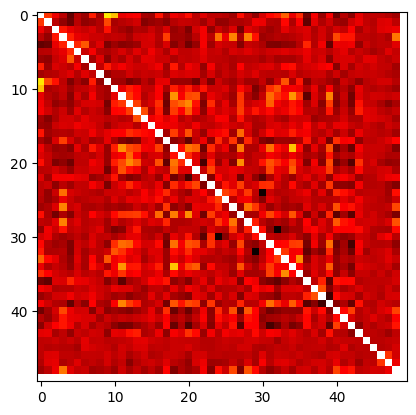

In [344]:
x = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

plt.imshow(x, cmap='hot', interpolation='nearest')

In [345]:
quality_map = {
    'Fa': 0.25,  # Fair
    'TA': 0.5,   # Typical
    'Gd': 0.75,  # Good
    'Ex': 1.0    # Excellent
}

df['ExterQual'] = df['ExterQual'].map(quality_map)
df['BsmtQual'] = df['BsmtQual'].map(quality_map)
df['KitchenQual'] = df['KitchenQual'].map(quality_map)
df['HeatingQC'] = df['KitchenQual'].map(quality_map)

In [358]:
quality_columns = ["ExterQual", "KitchenQual", "OverallQual"]

for column in quality_columns:
  for i, row in df.iterrows():
    if pd.isnull(row[column]):
      print(column, i)

In [367]:
df['Quality'] = 0

weights = combine_optimally_for_price("Quality", quality_columns)

print(weights)

df['Quality'].corr(df['SalePrice'])

[81061.77111767 82097.59903838 32691.42332861]


np.float64(0.8144187330738883)

Clearly space is the most important factor. So we combine them.

- Entire lot size LotArea
- 1st floor square feet
- basement square feet
- garage area
- front porch square feet
- 2nd floor square feet (weight this more because houses with two floors are significantly more expensive than houses with one floor)
-

In [379]:
column_to_correlation = {}

for column in df.select_dtypes(include=['number']).columns:
  column_to_correlation[column] = df[column].corr(df['SalePrice'])

columns_copy = list(df.select_dtypes(include=['number']).columns)

columns_copy.sort(key=lambda y: column_to_correlation[y])
columns_copy.reverse()

for c in columns_copy:
  print(c, column_to_correlation[c])

SalePrice 1.0
Quality 0.8144187330738883
TotalArea 0.8128165515546111
bathroom index 0.6560645304146158
HeatingQC nan
OverallQual 0.7909816005838044
ExterQual 0.6826392416562594
KitchenQual 0.6595997207286639
BsmtQual 0.6440193059937249
GarageCars 0.6404091972583529
GarageArea 0.6234314389183618
1stFlrSF 0.6058521846919147
Age 0.5773419469204323
FullBath 0.5606637627484449
TotRmsAbvGrd 0.5337231555820282
YearBuilt 0.5228973328794969
YearRemodAdd 0.5071009671113865
MasVnrArea 0.4774930470957163
Fireplaces 0.46692883675152724
BsmtFinSF1 0.3864198062421532
LotFrontage 0.35179909657067804
WoodDeckSF 0.3244134445681294
2ndFlrSF 0.3193338028320681
OpenPorchSF 0.3158562271160555
HalfBath 0.2841076755947831
LotArea 0.2638433538714056
BsmtFullBath 0.22712223313149382
BsmtUnfSF 0.21447910554696892
BedroomAbvGr 0.16821315430073988
MoSold 0.046432245223819384
BsmtFinSF2 -0.011378121450215125
YrSold -0.028922585168730378
OverallCond -0.07785589404867803
MSSubClass -0.08428413512659531
EnclosedPorch

In [377]:
df['Age'] = 0

combine_optimally_for_price('Age', ['YearBuilt', 'YearRemodAdd'])

df['Age'].corr(df['SalePrice'])

np.float64(0.5773419469204323)

In [378]:
df['bathroom index'] = 0

combine_optimally_for_price('bathroom index', ['FullBath', 'HalfBath', 'BsmtFullBath'])

df['bathroom index'].corr(df['SalePrice'])

np.float64(0.6560645304146158)